In [1]:
!pip install gym
!pip install stable_baselines3
!pip install numpy
!pip install matplotlib
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827621 sha256=9957ab4f459efc9f6c88b95588d758227f0839969129d74b616c97d17a0b6eda
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 21.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 51.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 58.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/1

In [2]:
!pip install imageio
!pip install procgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 7.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.1 MB/s eta 0:00:00


In [3]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import imageio


import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies_impala import ImpalaCNN
from src.visualisation_functions import *


env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



In [4]:
@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action

def load_model(model_path = 'model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= 200:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

In [27]:
model = load_model()

save_gif_option = True  
for episode in range(1):
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")



Episode 1 finished with total reward: 10.0


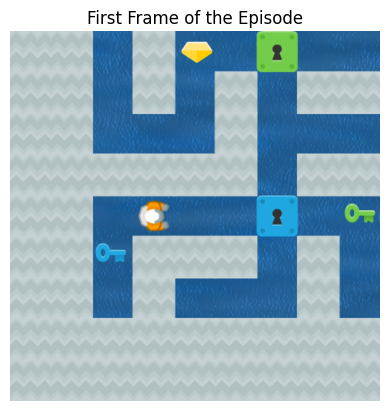

In [6]:
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")

In [7]:
import imageio

def create_gif(frames, filename, duration=0.1):
    # Write frames to GIF file
    imageio.mimsave(filename, frames, duration=duration)


create_gif(frames, "episode_gif.gif")


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def swap_colours(observation):
    blue_key_colors = [
        [27, 177, 232],
        [20, 150, 198],
        [22, 161, 212]
    ]
    green_key_colors = [
        [125, 212, 70],
        [98, 189, 34],
        [110, 195, 56]
    ]

    # Create a copy of the observation array to modify
    modified_observation = observation.copy()

    # Swap the colors of blue and green keys
    for blue_color, green_color in zip(blue_key_colors, green_key_colors):
        # Find pixels that match the blue color within a tolerance
        blue_mask = np.abs(observation - blue_color).sum(axis=-1) < 65
        modified_observation[blue_mask] = green_color

        # Find pixels that match the green color within a tolerance
        green_mask = np.abs(observation - green_color).sum(axis=-1) < 65
        modified_observation[green_mask] = blue_color
        

    return observation

    

def plot_heist_observation(observation):
    # Define the colors to swap

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the modified observation
    ax.imshow(observation)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()

In [9]:
[27, 177, 232] in observations[0]

True

In [10]:
!pip install opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 20.7 MB/s eta 0:00:0000:0100:01


In [20]:
#reading some images : blue key and gem only in opencv
import cv2
def convert_png_obs(image_png_name):
    image = cv2.imread(image_png_name)

    # Resize the image to match the original observation dimensions
    image = cv2.resize(image, (64, 64))

    # Convert the color format if necessary
    if image.shape[2] == 4:  # RGBA format
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape[2] == 1:  # Grayscale format
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Ensure the image data type matches the original observation
    image = image.astype(np.uint8)
    return image

def read_modified_image(filename):
    # Load the edited PNG image
    edited_image = cv2.imread(filename)

    # Resize the image to match the original observation dimensions
    resized_image = cv2.resize(edited_image, (64, 64))

    # Convert the color format if necessary
    if resized_image.shape[2] == 4:  # RGBA format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGBA2RGB)
    elif resized_image.shape[2] == 1:  # Grayscale format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    # Ensure the image data type matches the original observation
    resized_image = resized_image.astype(np.uint8)
    image_tensor = torch.from_numpy(resized_image)
    image_tensor =  image_tensor.unsqueeze(0)
    return image_tensor
# Use the resized_image as input to your model
# model.predict(resized_image)

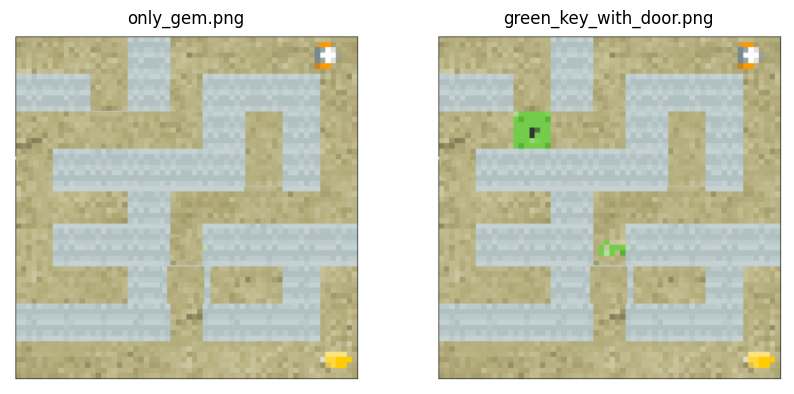

In [116]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_images_with_matplotlib(img_paths):
    fig, axes = plt.subplots(1, len(img_paths), figsize=(10, 5))
    if len(img_paths) == 1:  # Adjust if there's only one image to avoid indexing error
        axes = [axes]
    for ax, img_path in zip(axes, img_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Hide the axes
        ax.set_title(img_path.split('/')[-1])  # Set title as the image filename
    plt.show()

# Example usage
img_paths = ['only_gem.png', 'green_key_with_door.png']
visualize_images_with_matplotlib(img_paths)

In [112]:
only_gem_input = convert_png_obs('only_gem.png')
only_blue_key_input = convert_png_obs('blue_key_no_door.png')
tensor_gem = read_modified_image('only_gem.png')
tensor_blue_key = read_modified_image('blue_key_no_door.png')
tensor_green_key_door = read_modified_image('green_key_with_door.png')


In [103]:
import torch
import torch.distributions

class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations
        for path in layer_paths:
            self.register_hook_by_path(path, path.replace('.', '_'))
        output = self.model(input)
        return output, self.activations



In [117]:
# Usage example:
model_activations = ModelActivations(model)
layer_paths1 = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]
output1, activations1 = model_activations.run_with_cache(tensor_gem, layer_paths1)
model_activations.clear_hooks()
output2, activations2 = model_activations.run_with_cache(tensor_blue_key, layer_paths1)
tensor_green_key_door 
output2, activations3 = model_activations.run_with_cache(tensor_green_key_door, layer_paths1)


In [118]:
differences = {}
for key in activations1:
    # Compute the difference tensor for the current key
    difference = activations3[key][0] - activations1[key][0]
    
    # Store the difference tensor in a new dictionary
    differences[key] = difference
    print(difference.shape)

    # Check if there are any non-zero differences
    has_non_zero = torch.any(difference != 0)
    
    if has_non_zero:
        print(f"Key: {key} has non-zero differences.")
    else:
        print(f"Key: {key} has only zero differences.")
print(differences)

torch.Size([16, 64, 64])
Key: conv_seqs_0_conv has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv1 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv1 has non-zero differences.
torch.Size([32, 32, 32])
Key: conv_seqs_1_conv has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_2_conv has non-zero differences.
torch.Size([32, 8, 8])
Key: conv_seqs_2_res_block0_conv0 has non-zero differences.
torch.Size([32, 8,

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])


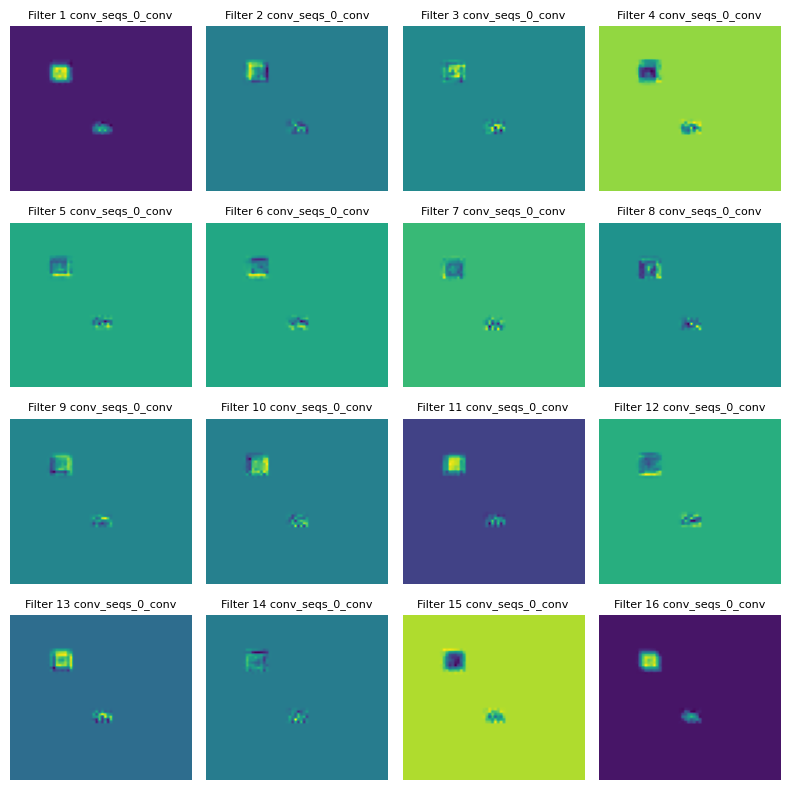

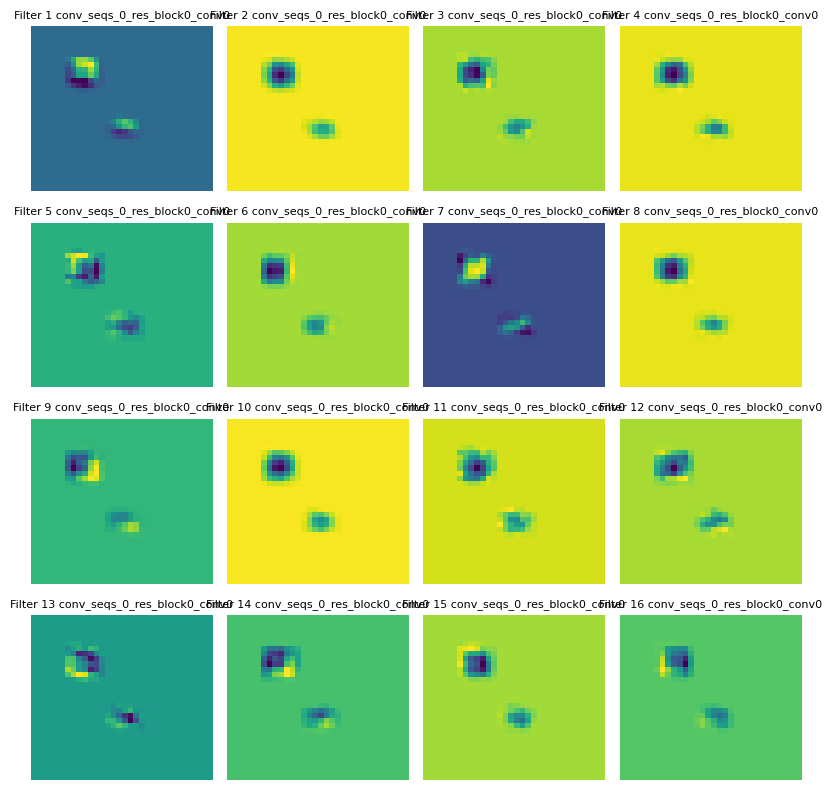

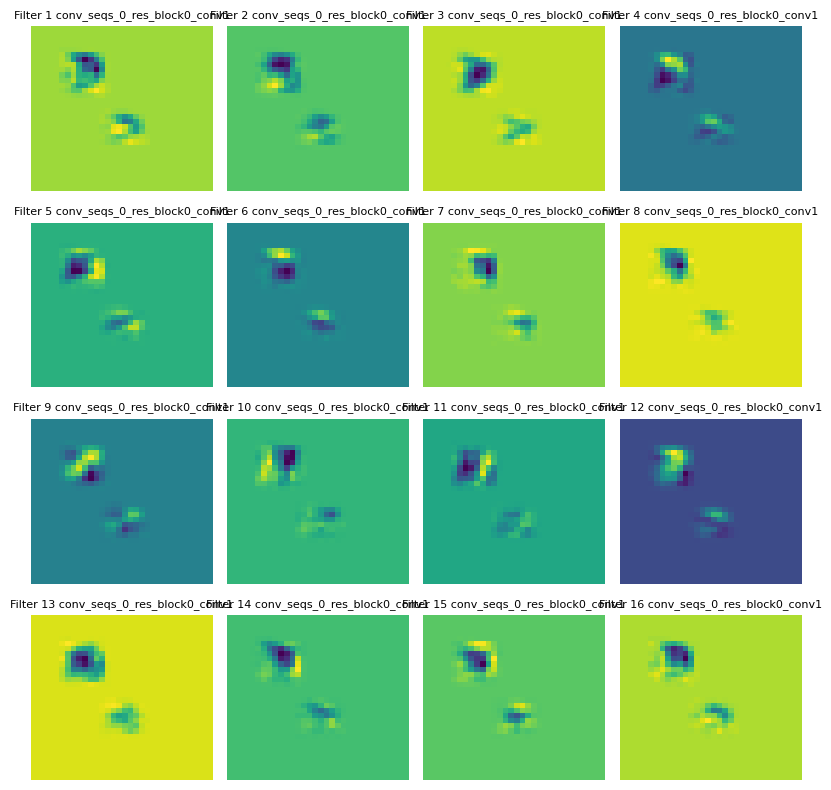

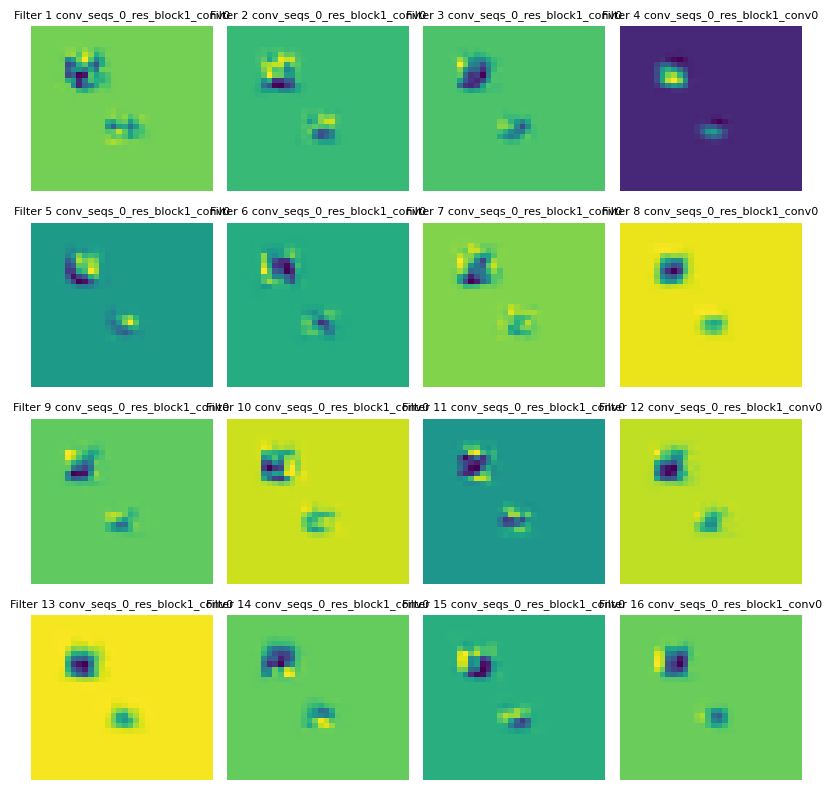

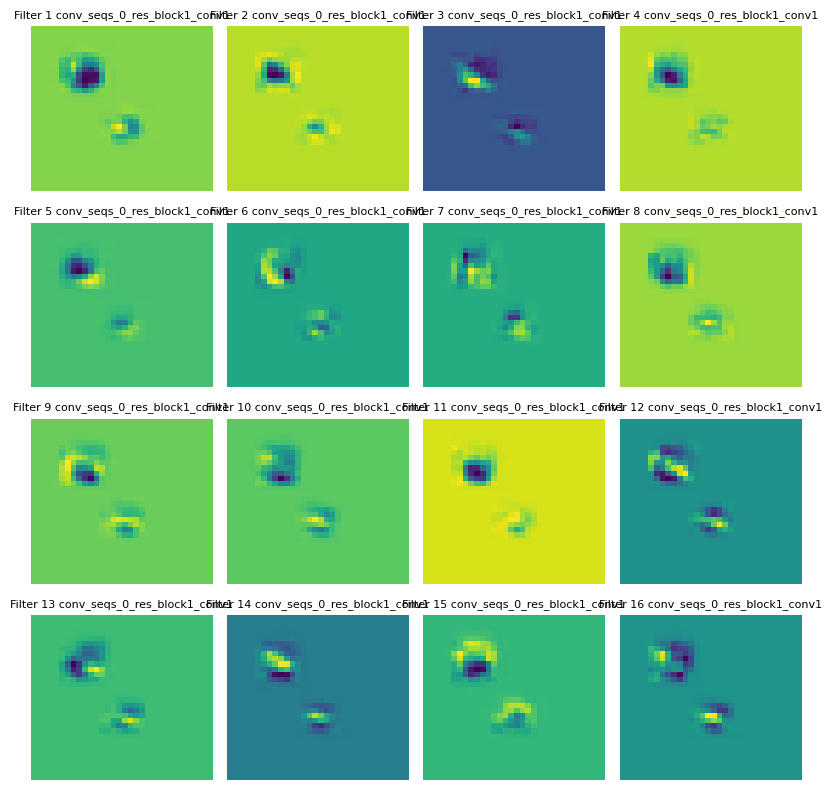

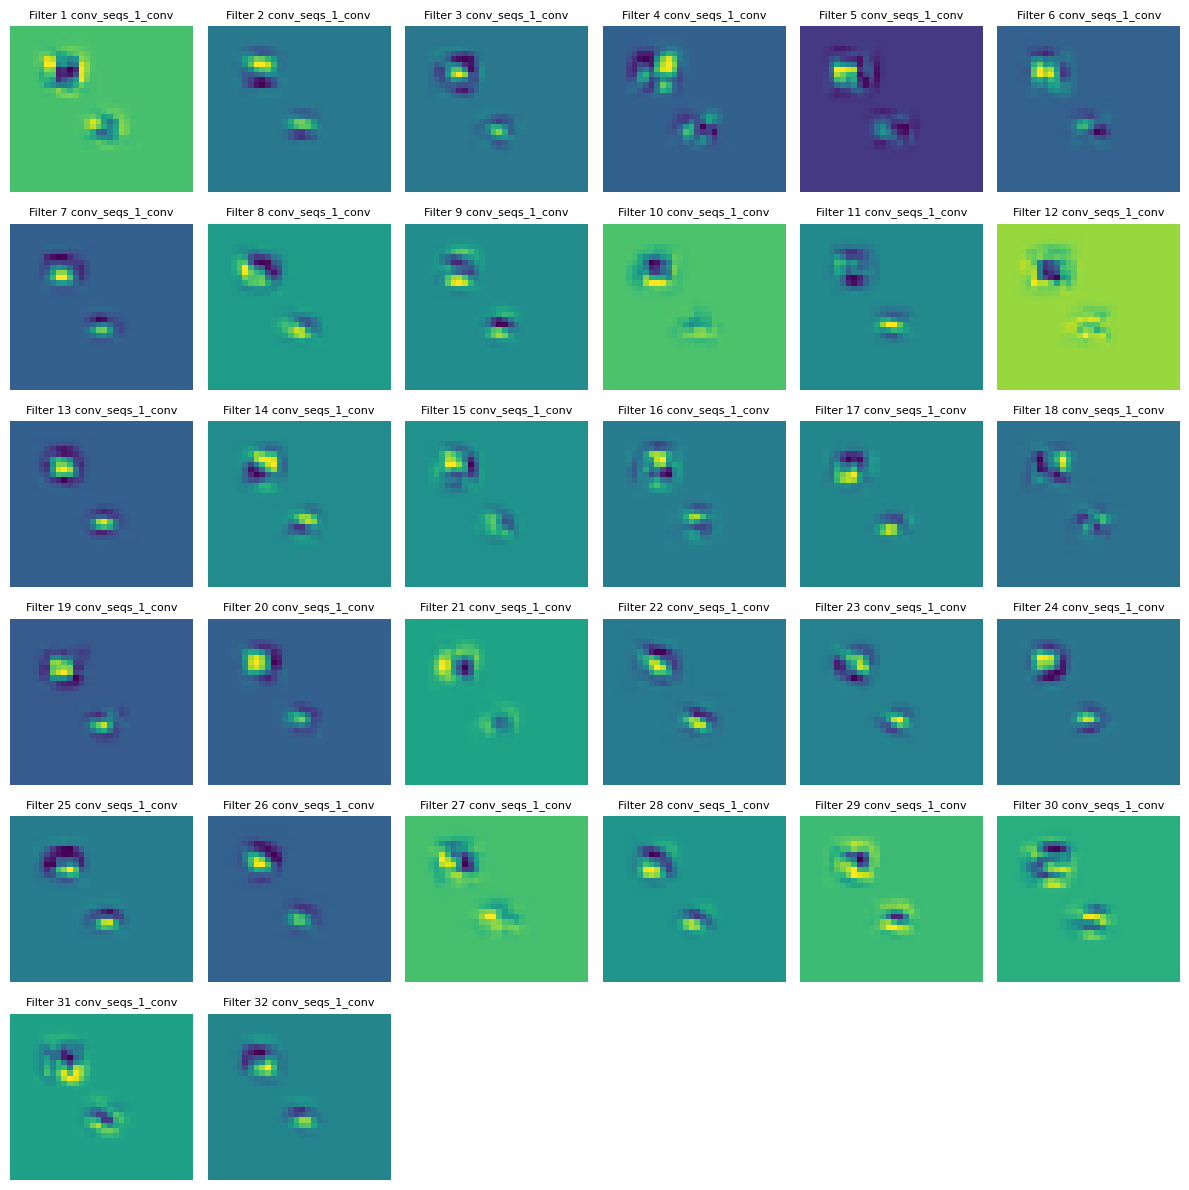

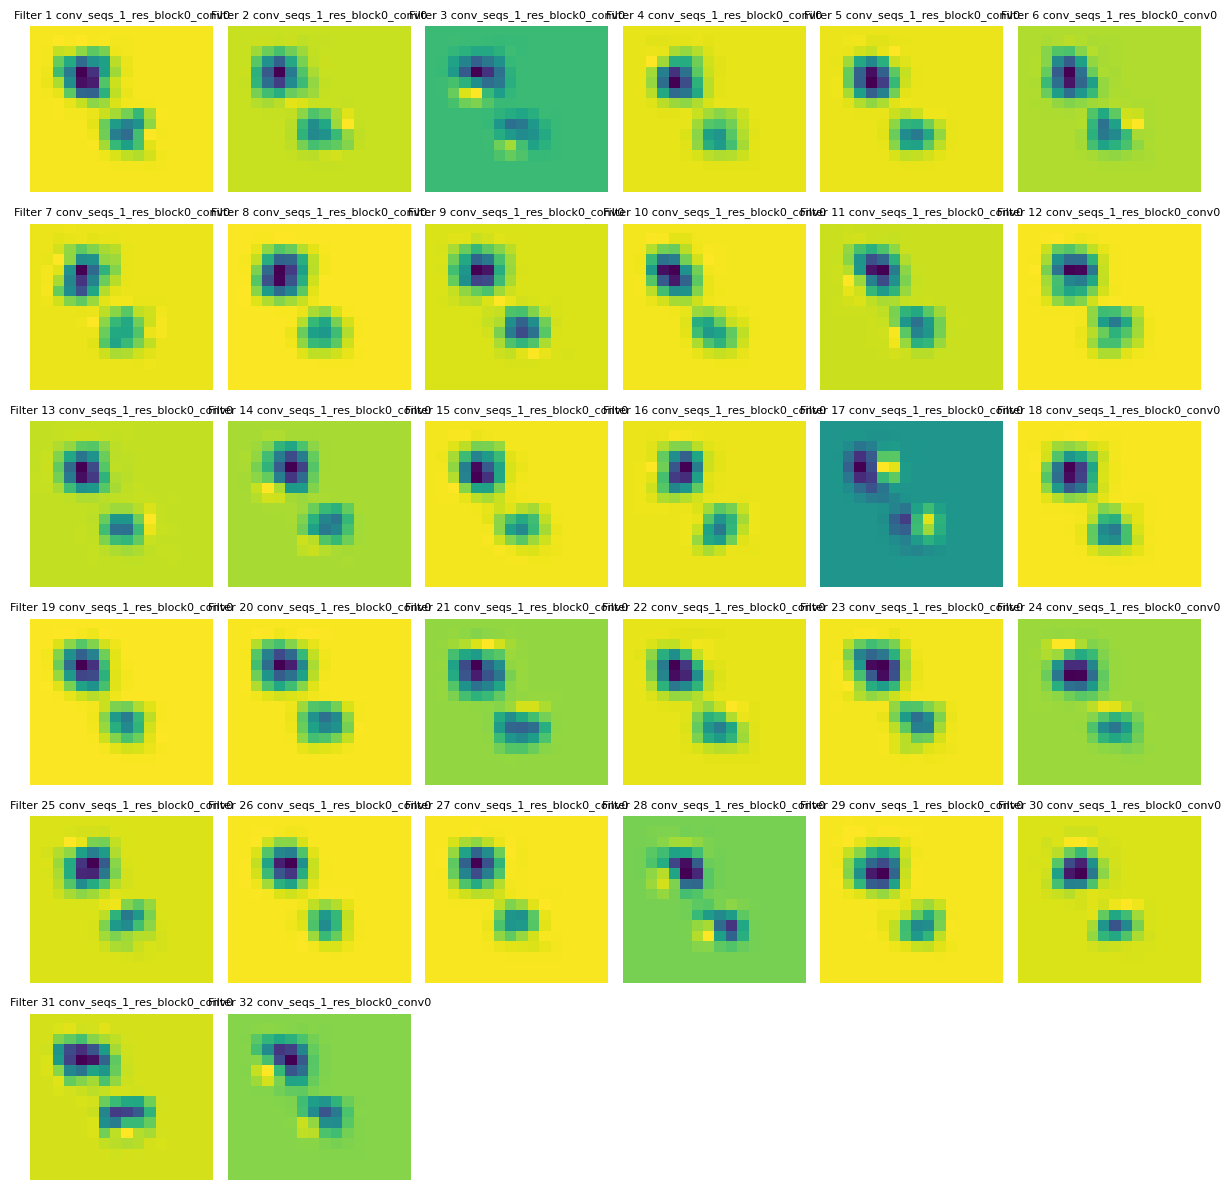

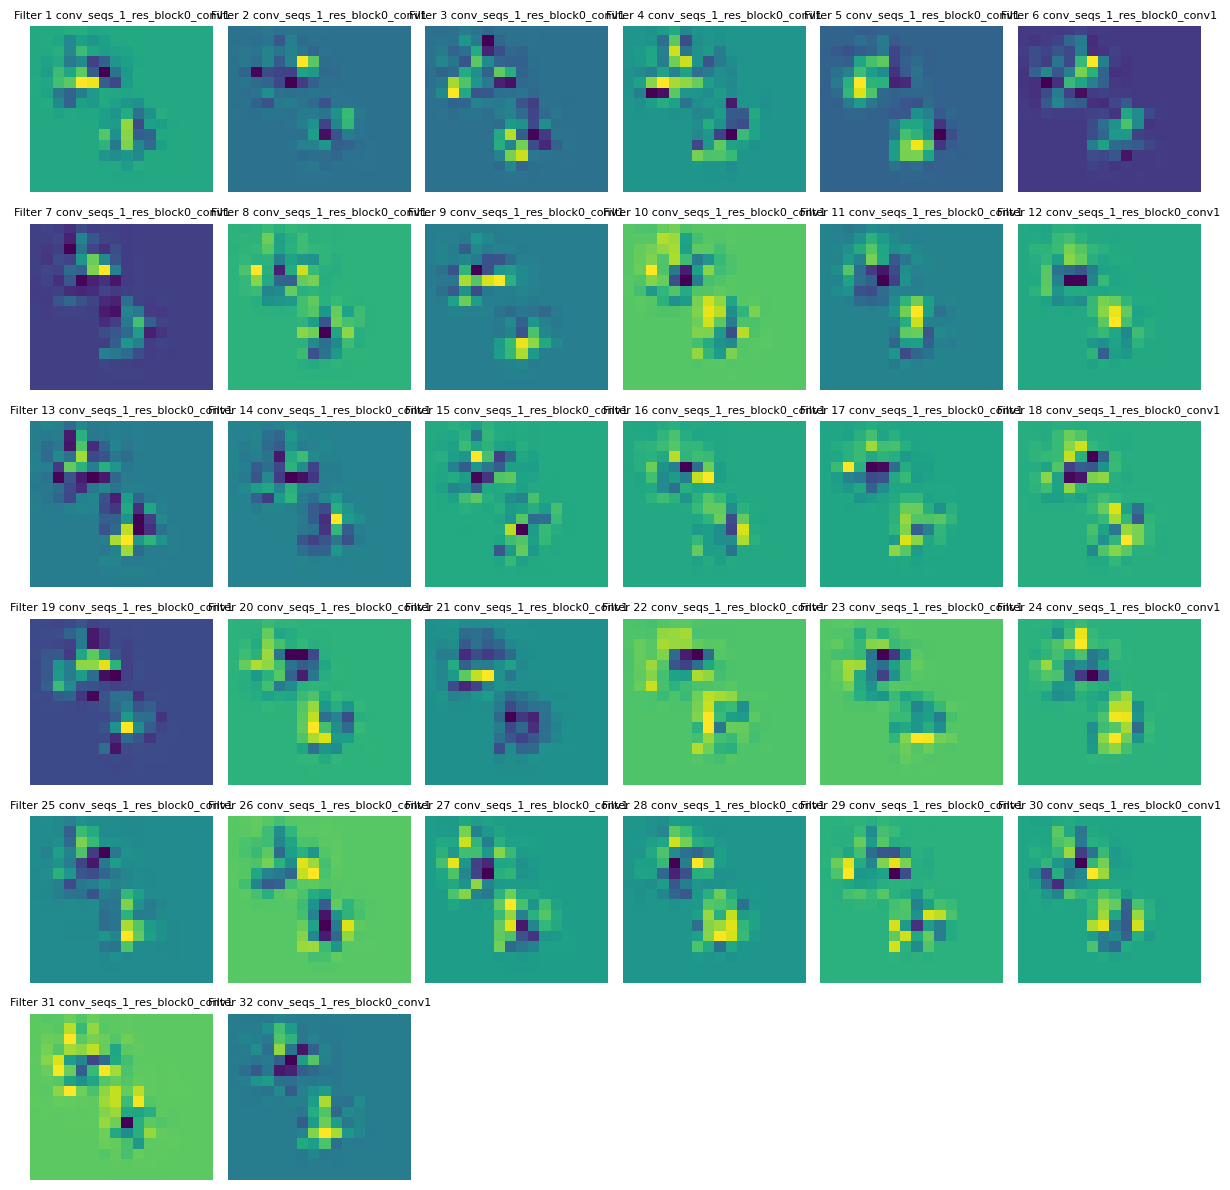

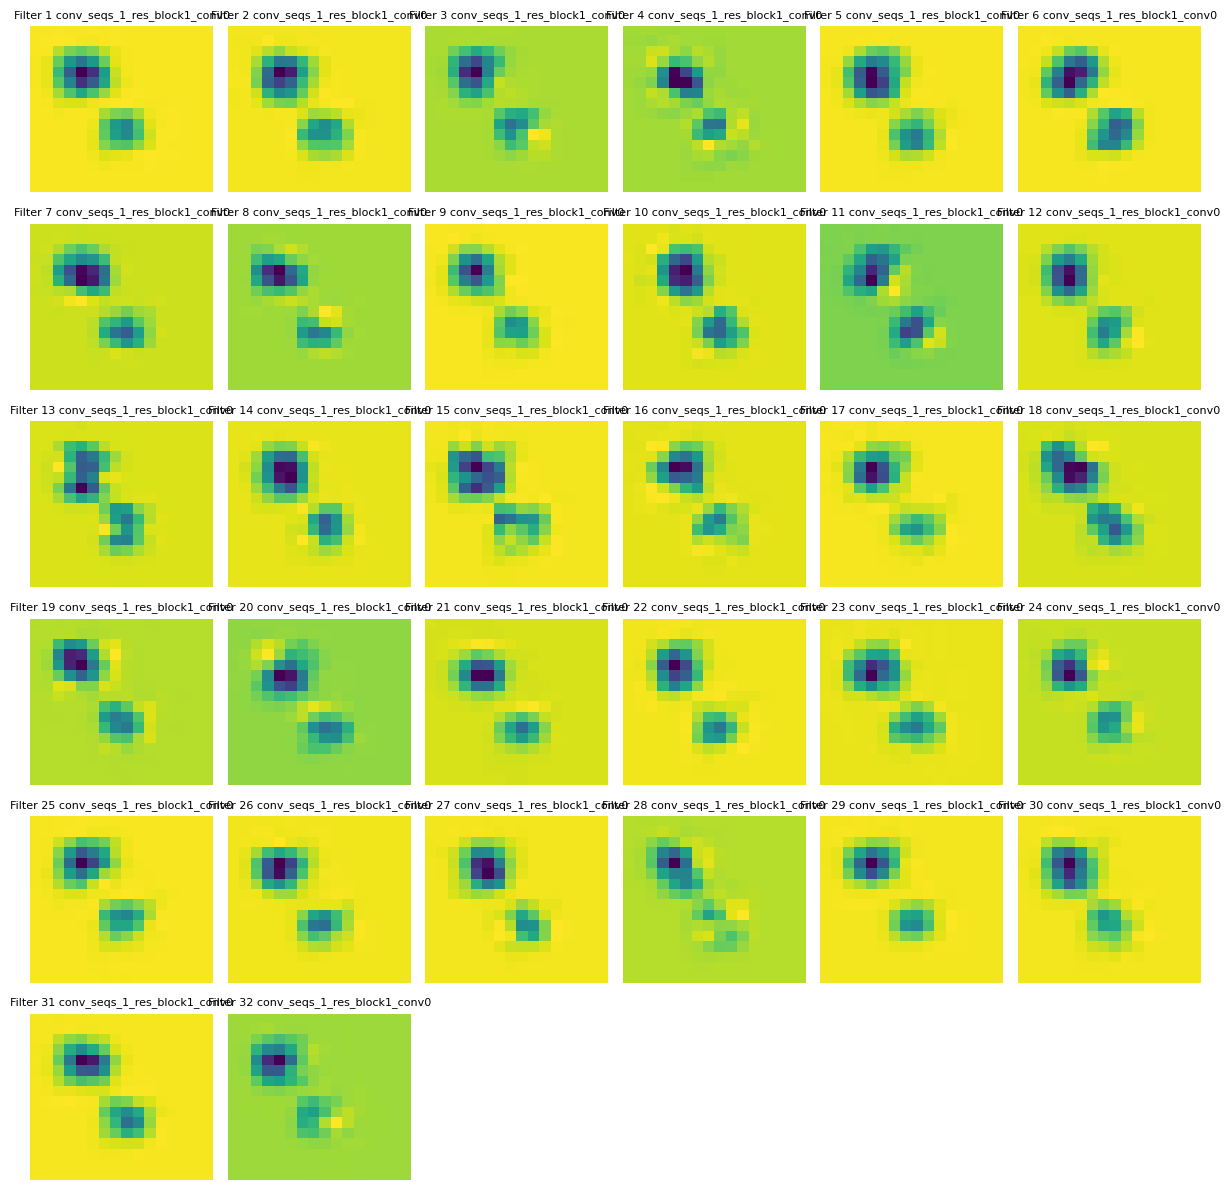

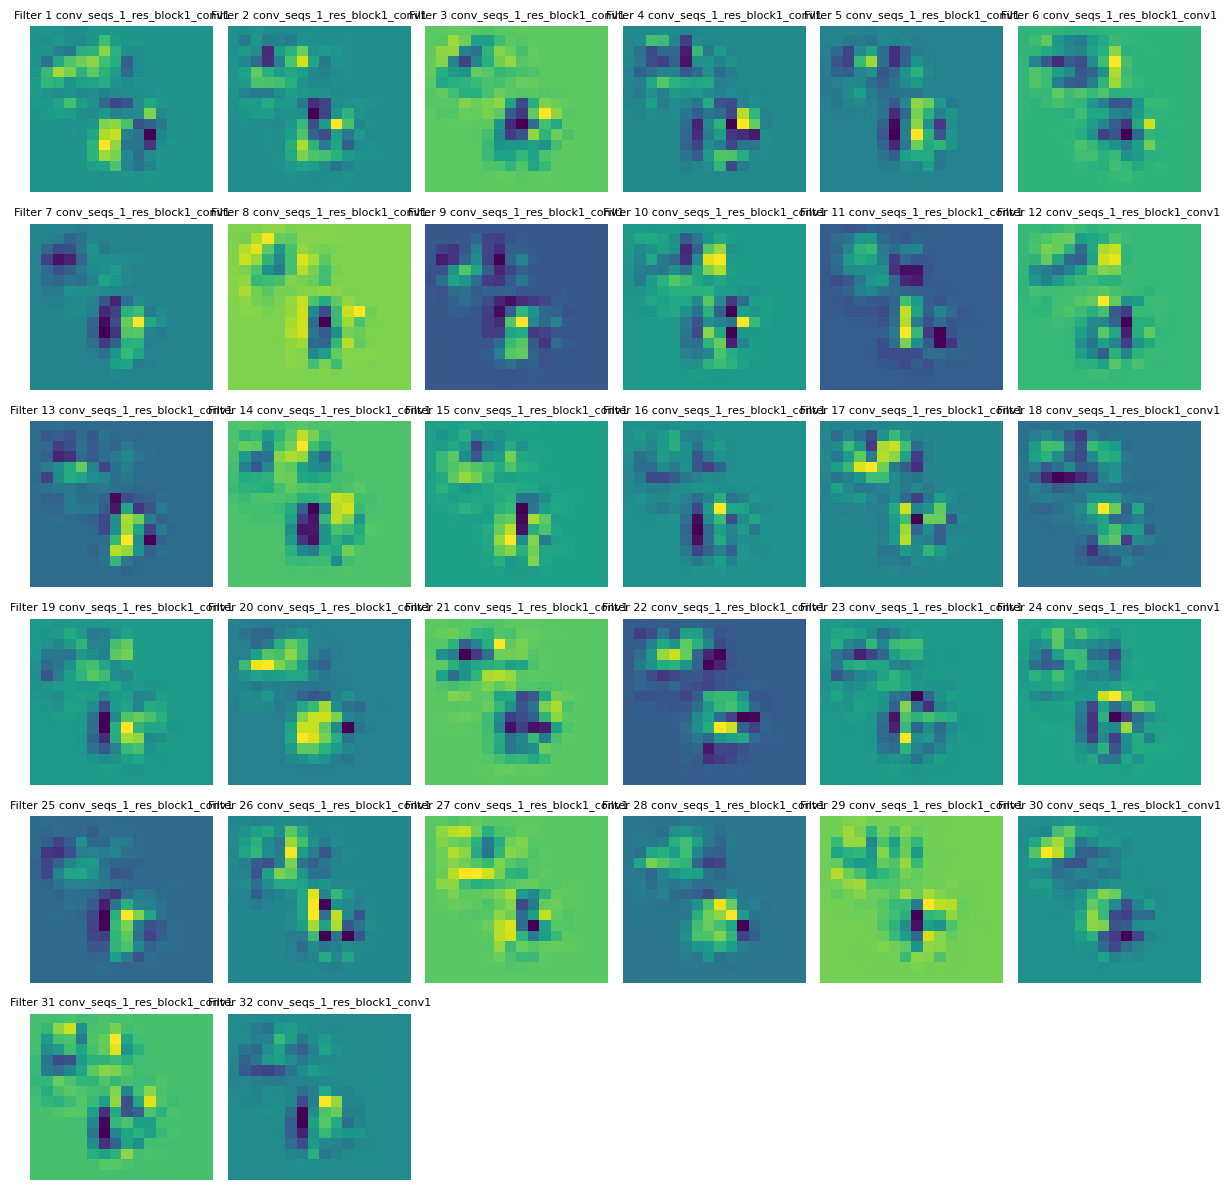

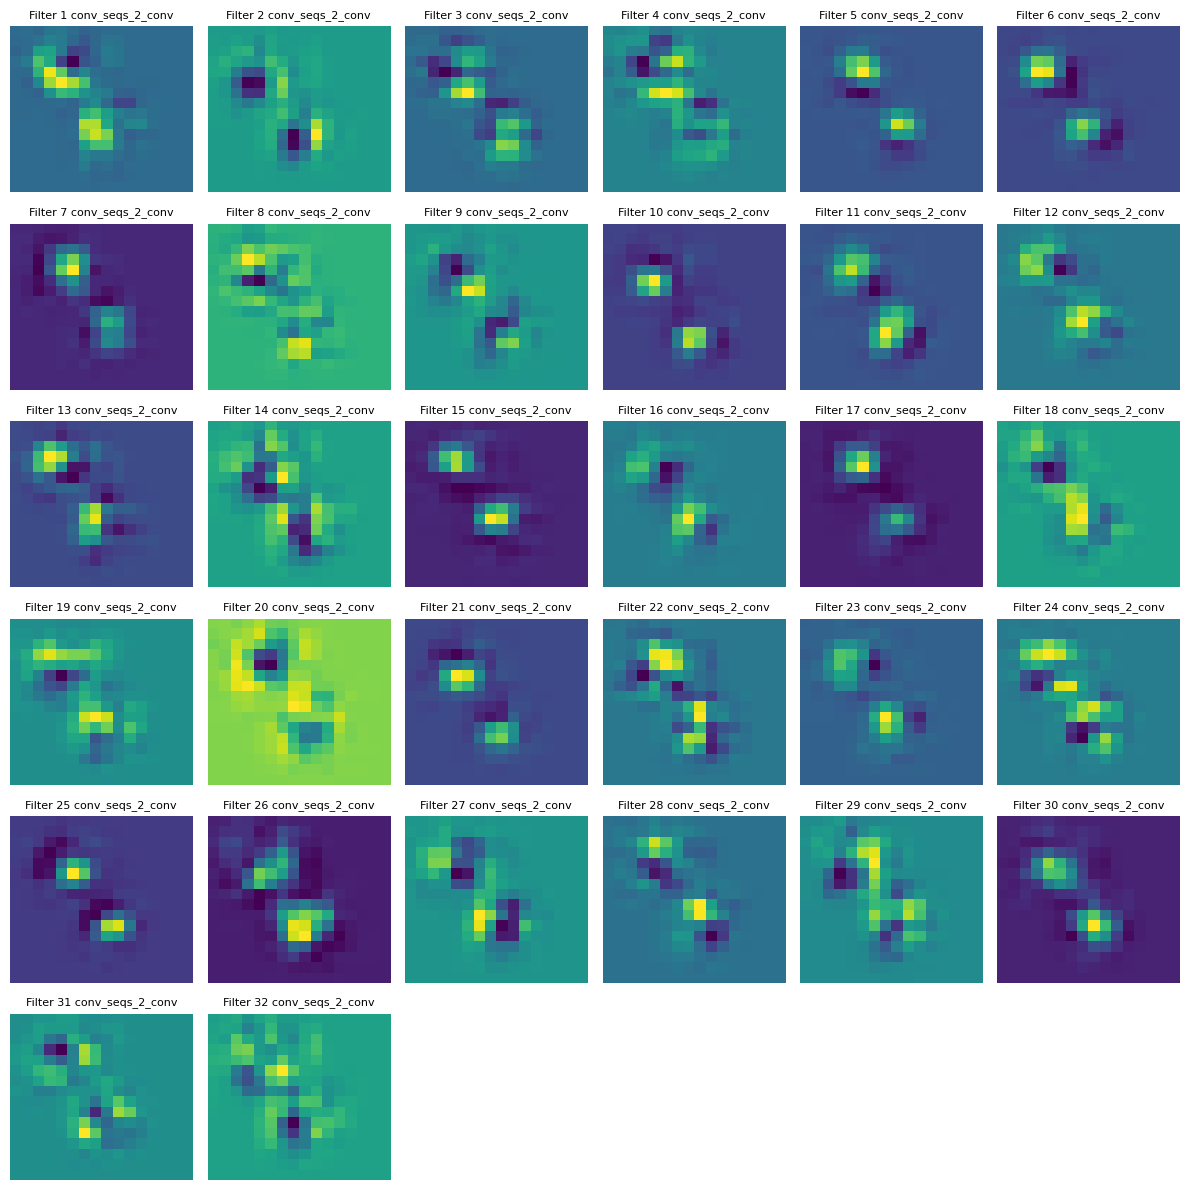

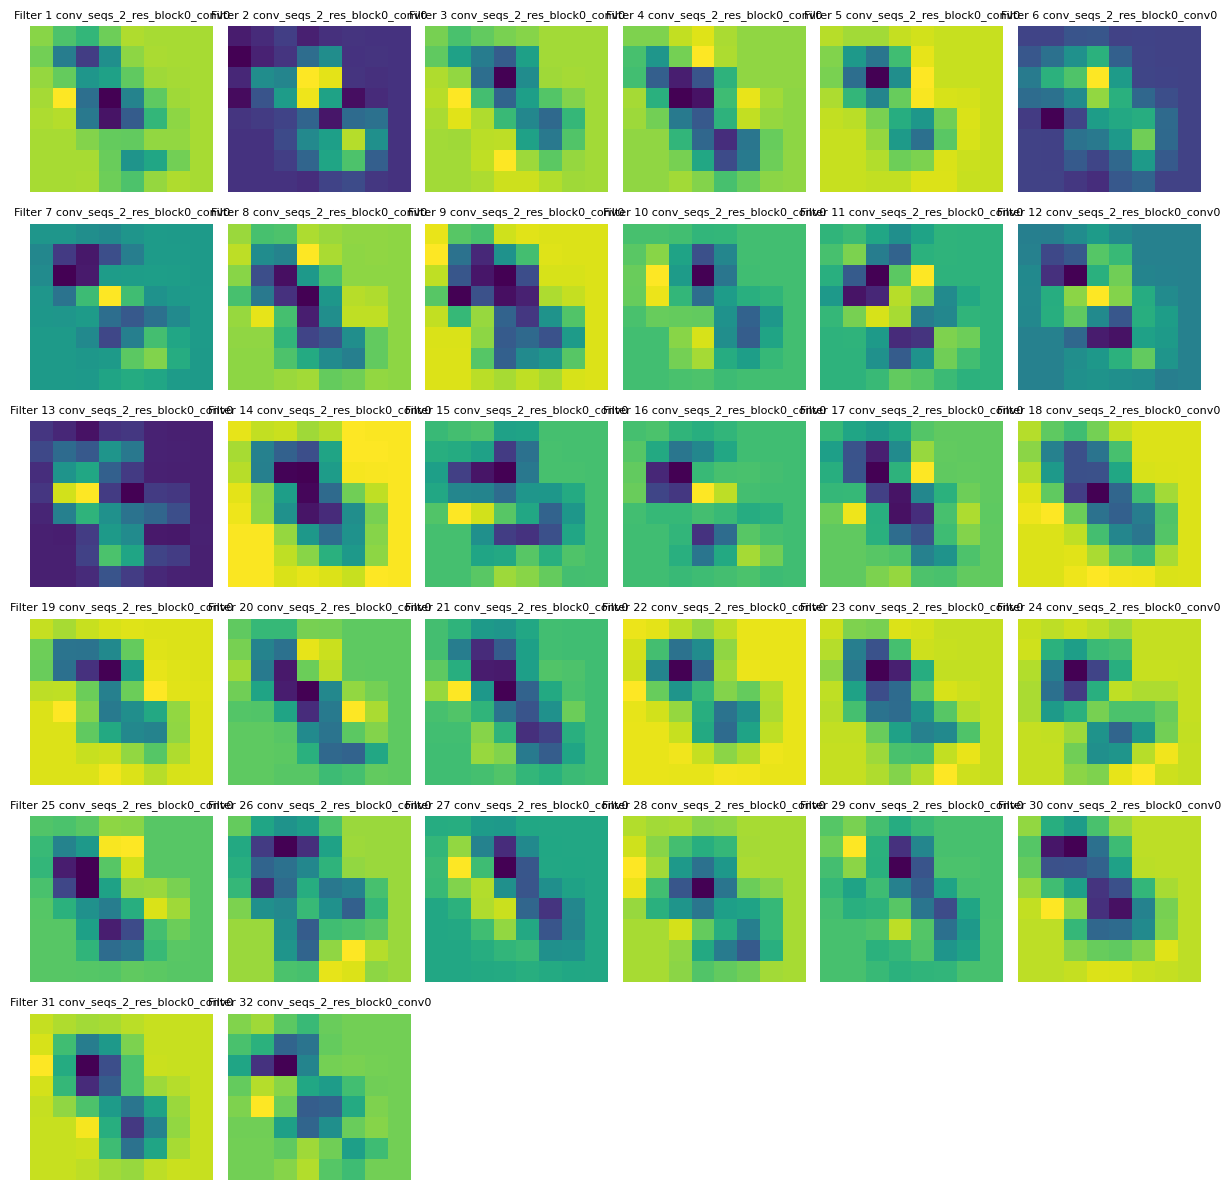

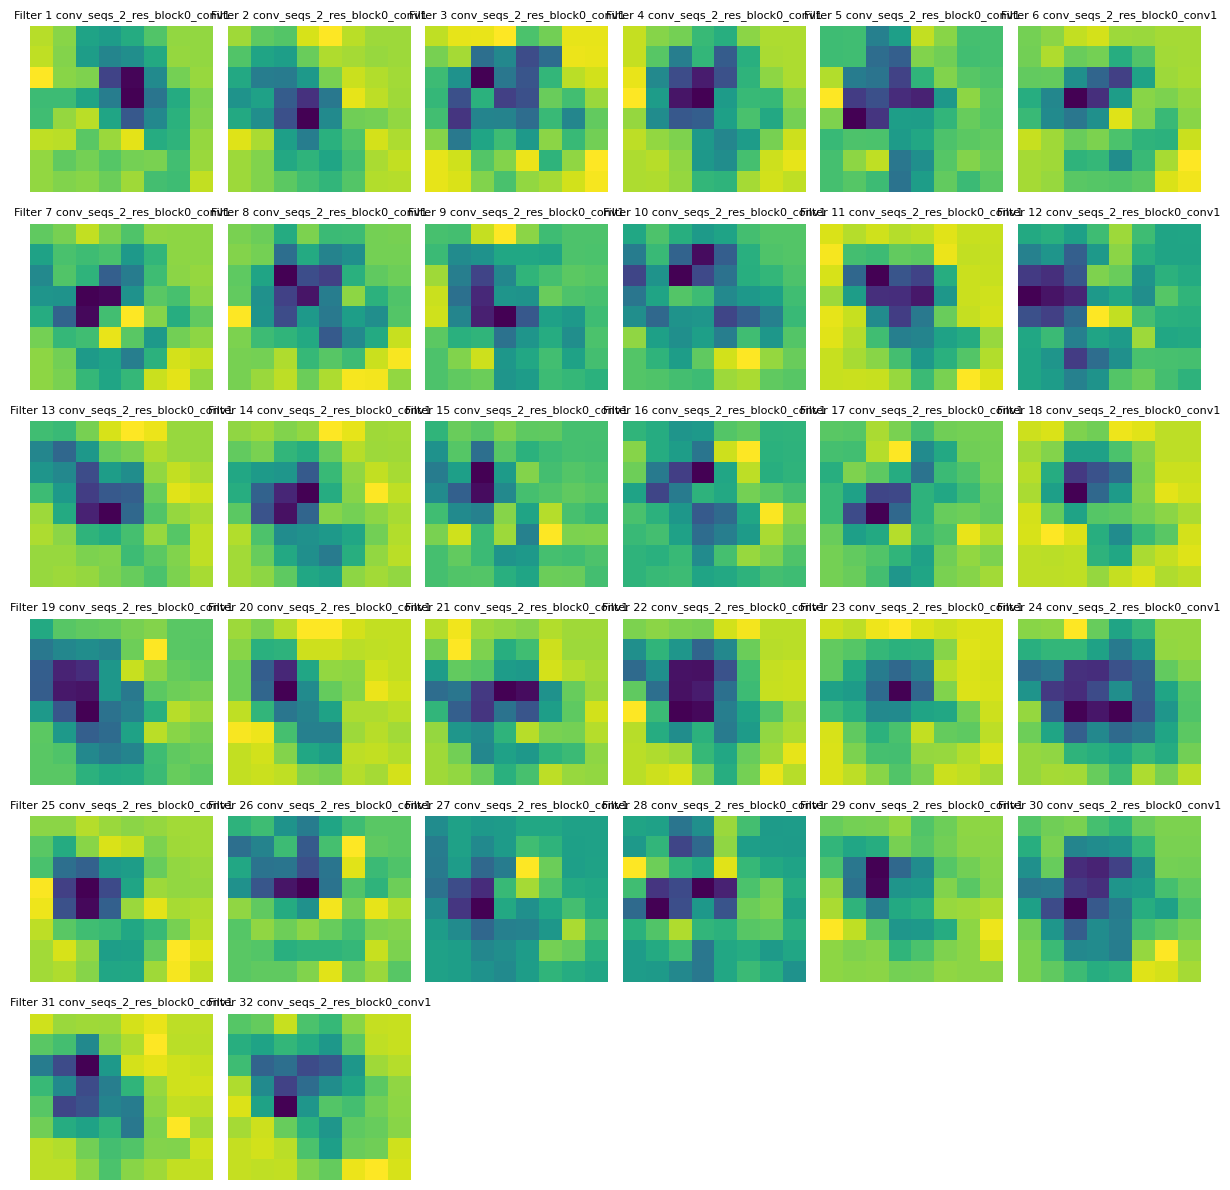

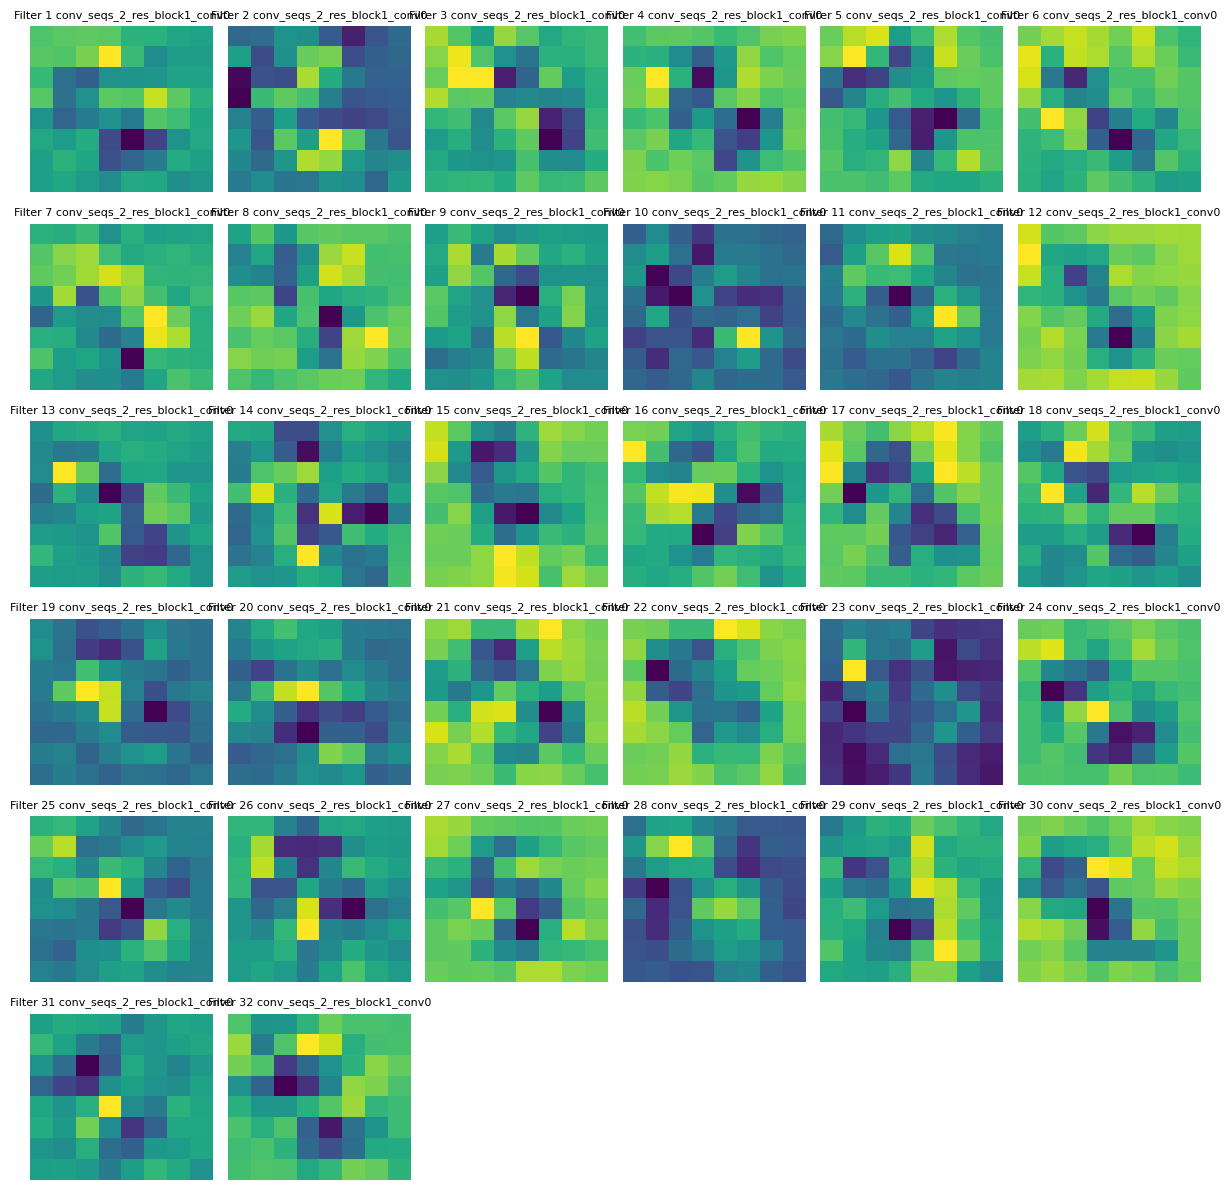

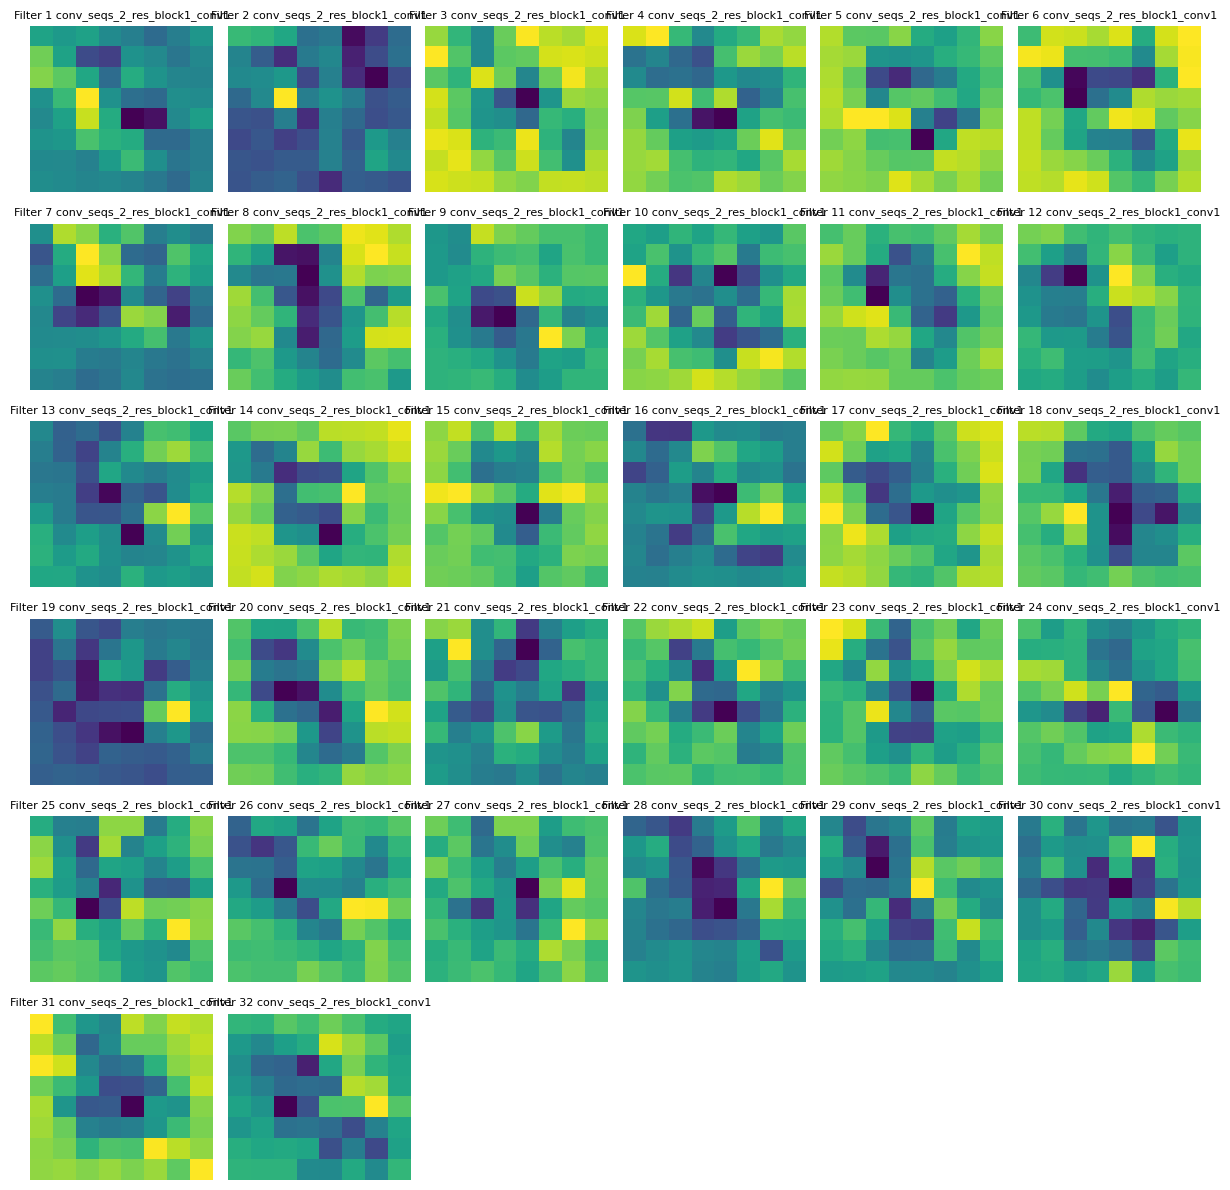

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_activations_for_layers(activations, layer_paths, save_filename_prefix=None):
    for layer_name in layer_paths:
        # Check if the specified layer's activations are available
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue

        # Extract the activation tensor for the specified layer
        activation_tensor = activations[layer_name].cpu().numpy()

        # The tensor is 3-dimensional [channels, height, width]
        num_activations = activation_tensor.shape[0]  # Number of activation maps
        
        # Calculate grid size
        grid_size = math.ceil(math.sqrt(num_activations))
        
        # Create a figure with dynamic subplots based on the number of activations
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        if grid_size == 1:
            axes = np.array([[axes]])  # Ensure axes can be indexed with two dimensions

        # Initialize an index for activation maps
        activation_idx = 0

        for i in range(grid_size):
            for j in range(grid_size):
                ax = axes[i, j]
                
                # Plot the activation map if we haven't gone through all of them yet
                if activation_idx < num_activations:
                    ax.imshow(activation_tensor[activation_idx, :, :], cmap='viridis', aspect='auto')
                    ax.set_title(f'Filter {activation_idx+1} {layer_name}', fontsize=8)
                    activation_idx += 1
                else:
                    ax.axis('off')  # Hide axes without data
                
                ax.axis('off')  # Hide axes for all plots for a cleaner look

        plt.tight_layout()
        
        # Save or show the plot
        if save_filename_prefix:
            save_filename = f"{save_filename_prefix}_{layer_name}.png"
            plt.savefig(save_filename)
            plt.close()
        else:
            plt.show()


layer_paths = differences.keys()
print(layer_paths)
plot_activations_for_layers(differences, layer_paths)


In [92]:
#the patching method
# Assuming you have already defined 'register_hook_by_path'

activations_cache = {}  # Dictionary to store activations

def save_activations(module, input, output, name):
    """Save the activations to the cache."""
    activations_cache[name] = output.detach()

def patch_activations(module, input, output, name):
    """Patch the activations from the cache."""
    if name in activations_cache:
        # Replace the current activations with the cached ones
        return activations_cache[name]

# Run the model with the first input
for name in layer_names:
    hook = model.register_forward_hook(lambda module, input, output: save_activations(module, input, output, name))
# forward pass with the first input to cache activations
output1 = model(first_input)
# remove the hooks to avoid saving activations in the next forward pass
for hook in hooks:
    hook.remove()

# Now run the model with the second input, patching in cached activations
hooks = []
for name in layer_names:
    hook = model.register_forward_pre_hook(lambda module, input: patch_activations(module, input, activations_cache, name))
# forward pass with the second input where cached activations will be patched in
output2 = model(second_input)
# remove the hooks after the forward pass
for hook in hooks:
    hook.remove()


NameError: name 'layer_names' is not defined

In [40]:
import matplotlib.pyplot as plt

def plot_all_layer_activations(activations, layer_names, max_cols=None, save_filename=None):
    # Determine the maximum number of filters across the specified layers
    max_filters = 0
    for layer_name in layer_names:
        if layer_name in activations:
            tensor_shape = activations[layer_name][0].shape
            num_filters = tensor_shape[0] if len(tensor_shape) == 3 else tensor_shape[1]
            if num_filters > max_filters:
                max_filters = num_filters
    max_filters = min(max_filters, max_cols) if max_cols is not None else max_filters
    
    # Create a figure with subplots
    num_layers = len(layer_names)
    fig, axes = plt.subplots(num_layers, max_filters, figsize=(max_filters * 2, num_layers * 2))
    
    for i, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue
        
        activation_tensor = activations[layer_name][0].cpu().numpy()
        # Adjust for tensors that are 3D (missing batch dimension)
        if activation_tensor.ndim == 3:
            activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
        
        num_filters = activation_tensor.shape[1]
        
        for j in range(max_filters):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            if j < num_filters:
                # Plot the activation map for filter j
                ax.imshow(activation_tensor[0, j, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'{layer_name}\nFilter {j+1}', fontsize=8)
                ax.axis('off')
            else:
                # Hide axes without data
                ax.axis('off')
    
    plt.tight_layout()

    if save_filename:
        plt.savefig(save_filename)
        plt.close() 
    else:
        plt.show()
        plt.show()

layer_names = [
    # 'conv_seqs_0_conv',
    # 'conv_seqs_0_res_block0_conv0',
    # 'conv_seqs_0_res_block0_conv1',
    # 'conv_seqs_0_res_block1_conv0',
    # 'conv_seqs_0_res_block1_conv1',
    'conv_seqs_1_conv',
    # 'conv_seqs_1_res_block0_conv0',
    # 'conv_seqs_1_res_block0_conv1',
    # 'conv_seqs_1_res_block1_conv0',
    # 'conv_seqs_1_res_block1_conv1',
    # 'conv_seqs_2_conv',
    # 'conv_seqs_2_res_block0_conv0',
    # 'conv_seqs_2_res_block0_conv1',
    # 'conv_seqs_2_res_block1_conv0',
    'conv_seqs_2_res_block1_conv1',
    # 'max_pool2d'
]


for i, observation in enumerate([only_gem_input]):
    # Run your data through the model
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    activations = {}
    output = model(observation)
    for layer_name in layer_names:
        plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=f"episode_{i}_{layer_name}_plot_later.png")

    # plot_all_layer_activations(activations, layer_names, max_cols=20, save_filename=f"../activation_plot_frames/episode_{i}_plot.png")


FileNotFoundError: [Errno 2] No such file or directory: '../activation_plot_frames/episode_0_conv_seqs_1_conv_plot_later.png'

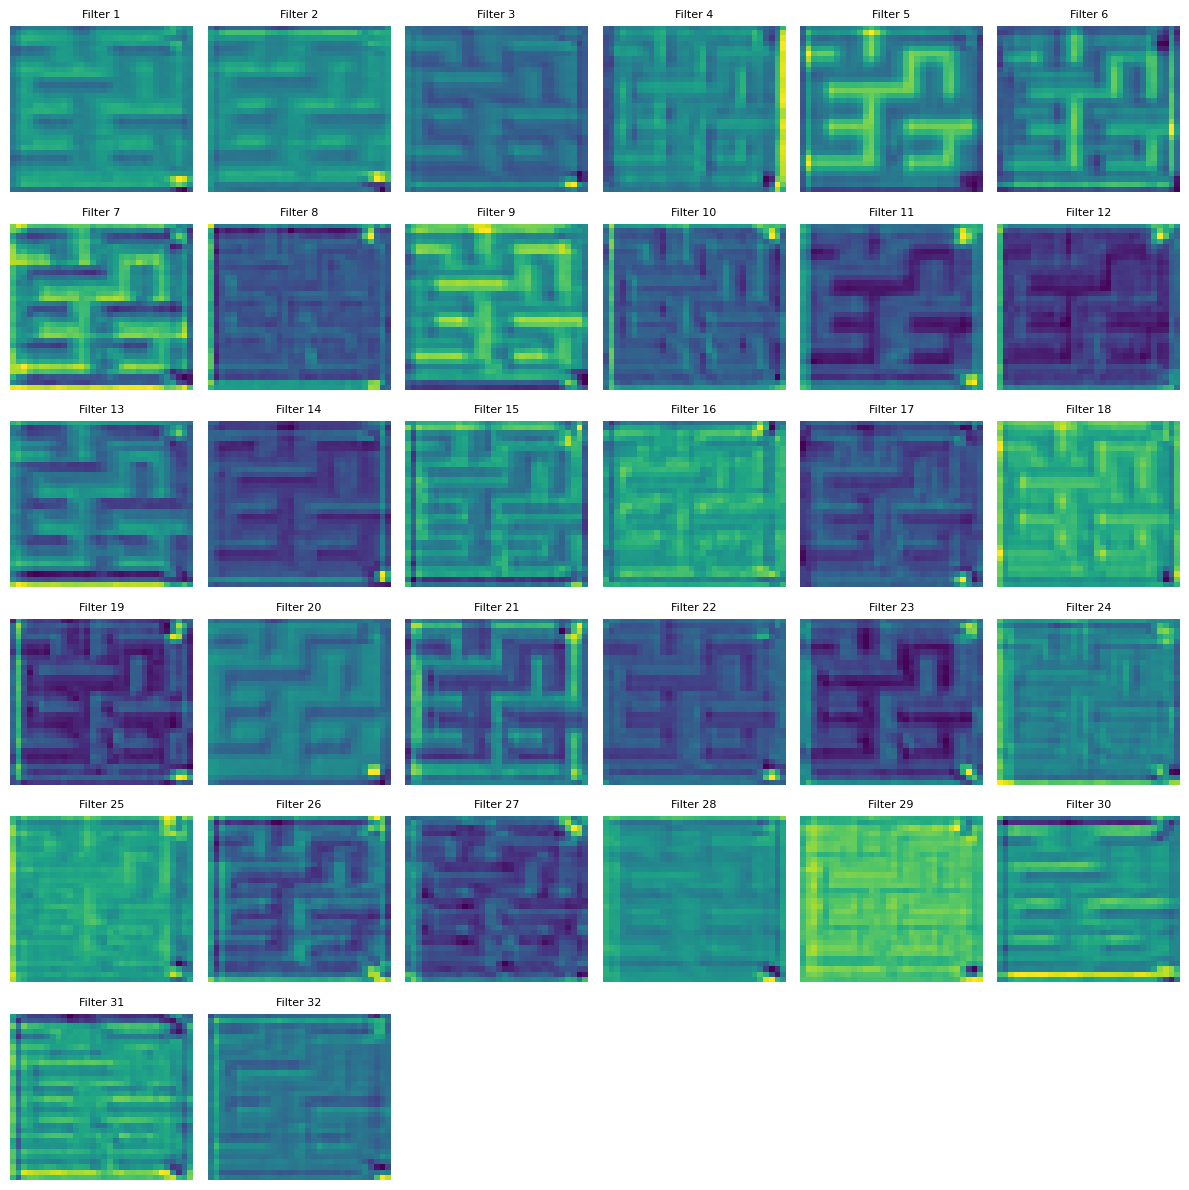

In [38]:
activations = {}
output = model(observation)
for layer_name in layer_names:
    plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=f"../activation_plot_frames/episode_{i}_{layer_name}_plot_later.png")


In [58]:
import glob
import imageio

def create_gif_from_folder(folder_path, gif_filename):
    # Construct the pattern to match the filenames
    pattern = f"{folder_path}/episode_*_plot.png"
    
    # Use glob to find matching filenames
    filenames = sorted(glob.glob(pattern), key=lambda x: int(x.split('_')[-2]))
    
    # Check if filenames list is not empty
    if not filenames:
        print("No files found matching the pattern. Please check the folder path and naming convention.")
        return
        
    # Create the GIF
    with imageio.get_writer(gif_filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"GIF created successfully: {gif_filename}")

# Example usage:
folder_path = "../activation_plot_frames"  # Adjust this path as needed
gif_filename = "activation_visualization.gif"  # Name of the output GIF file
create_gif_from_folder(folder_path, gif_filename)


No files found matching the pattern. Please check the folder path and naming convention.


In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.size()}")

Parameter name: conv_seqs.0.conv.weight, shape: torch.Size([16, 3, 3, 3])
Parameter name: conv_seqs.0.conv.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.1.conv.weight, shape: torch.Size([32, 16, 3, 3])
Parameter name: conv_seqs.1.conv.bias, shape: torch.Size([32])
Parameter name: conv_seqs.1.res_block0.conv0.weight, shape: torch.Size([32, 3

In [ ]:
#inputs the 2 images 
#Take away those the activations from one image to the other
#function that is called read modified image
def residual_mean_ablate(seed=IntSlider(min=0, max=20, step=1, value=0), block=Dropdown(options=[1, 2, 3], value=1), res=Dropdown(options=[1, 2], value=1), component=Dropdown(options=residual_components, value='conv1_out')):
    layer_name = f'embedder.block{block}.res{res}.{component}'
    hook.run_with_input(obs)
    random_values = hook.get_value_by_label(layer_name)
    patches = get_mean_patch(values=random_values, layer_name=layer_name) 
    
    venv = create_venv(num=1, start_level=seed, num_levels=1)
    fig, axs, info = compare_patched_vfields(venv, patches, hook, ax_size=5, show_diff = True)
    
    fig.suptitle(f'Mean patching layer {layer_name}')
    plt.show()